In [1]:
import pandas as pd
import numpy as np
from BorutaShap import BorutaShap

full = pd.read_csv('InputPythonUTF8.csv')

In [2]:
full.columns = full.columns.str.replace(".", "-")

In [3]:
oneday_races_cobbles = ['omloop-der-vlaamse-gewesten2'
  ,'paris-roubaix-juniors'
  ,'ronde-van-vlaanderen-juniores'
  ,'tour-des-flandres-espoirs'
  ,'paris-roubaix-espoirs'
  ,'kattekoers']

oneday_races_MJ = ['bernaudeau-junior'
  ,'gp-general-patton'
  ,'gp-dell-arno'
  ,'trofeo-buffoni'
  ,'trofeo-comune-di-vertova'
  ,'trofeo-emilio-paganessi'
  ,'le-trophee-centre-morbihan'
  ,'european-championship-mj'
  ,'uci-world-championships-mj']

oneday_races_hilly_U23 = ['liege-bastogne-liege-u23'
  ,'coppa-della-pace-trofeo-flli-anelli'
  ,'gp-palio-del-recioto'
  ,'gp-capodarco'
  ,'gran-premio-della-liberazione'
  ,'gp-industrie-del-marmo'
  ,'gp-di-poggiana'
  ,'piccolo-giro-di-lombardia'
  ,'ruota-d-oro-gp-festa-del-perdono'
  ,'gp-industria-e-commercio2'
  ,'trofeo-piva'
  ,'circuito-belvedere'
  ,'world-championships-u23'
  ,'european-championships']

rest_races = ['le-triptyque-des-monts-et-chateaux'
  ,'olympias-tour'
  ,'tour-de-normadie'
  ,'tour-de-berlin'
  ,'paris-arras-tour'
  ,'paris-tours-u23'
  ,'eschborn-frankfurt-u23'
  ,'zlm-tour']

stageraces_climb = ['ronde-de-l-isard'
  ,'tour-alsace']

stageraces_MJ = ['tour-du-valromey'
,'liege-la-gleize'
,'course-de-la-paix-junior'
,'grand-prix-ruebliland'
,'keizer-der-juniores'
,'la-coupe-du-president-de-la-ville-de-grudziadz'
,'trofeo-karlsberg'
,'sint-martinusprijs-kontich'
,'driedaagse-van-axel'
,'tour-de-l-abitibi'
,'tour-du-pays-de-vaud'
,'giro-internazionale-della-lunigiana'
,'tour-de-l-abitibi'
,'int-junioren-rundfahrt-niedersachsen']

ITT_races = [
  'uci-world-championships-itt-mj'
  ,'chrono-des-nations-les-herbiers-vendee-mj'
  ,'world-championships-itt-u23'
  ,'european-championships-itt-u23']

big_tours = ['tour-de-l-avenir'
             ,'giro-ciclistico-d-italia'
             ,'giro-ciclistico-della-valle-d-aosta-mont-blanc'
             ,'tour-des-pays-de-savoie']

In [4]:
oneday_races_cobbles_col = [s for s in full.columns if any(xs in s for xs in oneday_races_cobbles)]
oneday_races_MJ_col = [s for s in full.columns if any(xs in s for xs in oneday_races_MJ)]
oneday_races_hilly_U23_col = [s for s in full.columns if any(xs in s for xs in oneday_races_hilly_U23)]
rest_races_col = [s for s in full.columns if any(xs in s for xs in rest_races)]
stageraces_climb_col = [s for s in full.columns if any(xs in s for xs in stageraces_climb)]
stageraces_MJ_col = [s for s in full.columns if any(xs in s for xs in stageraces_MJ)]
ITT_races_col = [s for s in full.columns if any(xs in s for xs in ITT_races)]
big_tours_col = [s for s in full.columns if any(xs in s for xs in big_tours)]

oneday_races_hilly_U23_col = [i for i in oneday_races_hilly_U23_col if "itt-u23" not in i]

t = [oneday_races_cobbles_col,oneday_races_MJ_col,oneday_races_hilly_U23_col,rest_races_col,stageraces_climb_col,stageraces_MJ_col,ITT_races_col,big_tours_col]
race_col = [item for sublist in t for item in sublist]

complete_var = np.setdiff1d(full.columns,race_col)

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
import time

def impute(imputation_method, train, val, test, complete_var):
    
    start_time = time.time()
    
    if imputation_method=='mean':
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    elif  imputation_method=='regression':    
        imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=500), max_iter=10, random_state=516)
    elif  imputation_method=='knn':  
        imputer = KNNImputer(n_neighbors=5, weights="uniform")    
    else:
        print('wrong imputation method')
    
    flat_list = [item for sublist in t for item in sublist]
    with_complete = [complete_var, flat_list]
    col_store = [item for sublist in with_complete for item in sublist]

    if imputation_method=='knn': 
        

        train_impute =  train[complete_var]
        test_impute = test[complete_var]
        val_impute = val[complete_var]
        
        for columns in t:
            total_col = [columns, complete_var]
            total_col = [item for sublist in total_col for item in sublist]

            train_tussen = train[total_col]
            test_tussen = test[total_col]
            val_tussen = val[total_col]

            imputer.fit(train_tussen)

            train_tussen = pd.DataFrame(imputer.transform(train_tussen))
            test_tussen = pd.DataFrame(imputer.transform(test_tussen))
            val_tussen = pd.DataFrame(imputer.transform(val_tussen))

            train_tussen.columns = total_col
            test_tussen.columns = total_col
            val_tussen.columns = total_col

            train_tussen = train_tussen[columns]
            test_tussen = test_tussen[columns]
            val_tussen = val_tussen[columns]

            train_impute.reset_index(drop=True, inplace=True)
            train_tussen.reset_index(drop=True, inplace=True)
            val_impute.reset_index(drop=True, inplace=True)
            val_tussen.reset_index(drop=True, inplace=True)
            test_impute.reset_index(drop=True, inplace=True)
            test_tussen.reset_index(drop=True, inplace=True)

            train_impute = pd.concat([train_impute, train_tussen], axis = 1, ignore_index = True)
            val_impute = pd.concat([val_impute, val_tussen], axis = 1, ignore_index = True)
            test_impute = pd.concat([test_impute, test_tussen], axis = 1, ignore_index = True)


    else:
        train_impute = train
        val_impute = val
        test_impute = test
        
        imputer.fit(train_impute)

        train_impute = pd.DataFrame(imputer.transform(train_impute))
        val_impute = pd.DataFrame(imputer.transform(val_impute))
        test_impute = pd.DataFrame(imputer.transform(test_impute))    

    train_impute.columns = col_store 
    val_impute.columns = col_store 
    test_impute.columns = col_store
    
    imputation_time = time.time() - start_time
       
    return(imputation_time, train_impute, val_impute, test_impute) 

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
num_rounds = [50,100,150,200,250,300,350,400]
gammas = [0,4,8,12,16,20]
depths = [6,7,8,9,10,11,12]
objs = ['reg:squarederror','reg:tweedie']
reg_as = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_ls = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

lambdas = [0.001,0.005,0.01,0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]

import multiprocessing
import itertools

def get_chunks(iterable, chunks=1):
    # This is from http://stackoverflow.com/a/2136090/2073595
    lst = list(iterable)
    return [lst[i::chunks] for i in range(chunks)]

def worker_DT(pairs):
        waarde = 0
        final_alpha = 0
        for lam in pairs:
            mod = DecisionTreeRegressor(ccp_alpha = lam)
            mod.fit(X_train, y_train)
            predictions = mod.predict(X_val)
            waarde2 = spearmanr(y_val, predictions).correlation
            if waarde2>waarde:                    
                final_alpha = lam
                waarde = waarde2
                print(waarde2)
                print('update')
        return waarde, final_alpha

def worker_XGB(pairs):    
    waarde = 0
    final_gamma = 0
    final_lr = 0
    final_rounds = 0
    final_depth = 0
    final_obj = ''
    final_alpha = 0
    final_lambda = 0
    
    for gamma, lr, rounds, depth, objecti, reg_al, reg_lam in pairs:
        xgb_model = XGBRegressor(max_depth = depth, reg_alpha = reg_al, reg_lambda = reg_lam, objective=objecti, n_estimators=rounds, gamma = gamma, eta = lr)
        xgb_model.fit(X_train, y_train)
        predictions = xgb_model.predict(X_val)
        waarde2 = spearmanr(y_val, predictions).correlation
        if waarde2>waarde:                    
            final_gamma = gamma
            final_lr = lr
            final_rounds = rounds
            final_depth = depth
            final_obj = objecti
            final_alpha = reg_al
            final_lambda = reg_lam
            waarde = waarde2
            print(waarde2)
            print('update')
    return waarde, final_gamma , final_lr, final_rounds, final_depth, final_obj, final_alpha, final_lambda
            
            

def render_predictions(X_train, y_train, X_val, y_val, X_test):

    X_trainBig = pd.concat([X_train, X_val], axis = 0)    
    y_trainBig = np.concatenate((y_train, y_val))

    X_trainBig.columns = X_train.columns
    
    print('Linear Regression')

    linreg = LinearRegression()
    linreg.fit(X_trainBig, y_trainBig)    
    predictions_linreg = linreg.predict(X_test)
    
    print('Decision Tree')
   
    jobs = []
    pairs = itertools.product(lambdas)
    chunked_pairs = get_chunks(pairs, chunks=multiprocessing.cpu_count())
    pool = multiprocessing.Pool()
    results = pool.map(worker_DT, chunked_pairs)
    pool.close()
    pool.join()
    
    sorted_results = reversed(sorted(results, key=lambda x: x[0]))[0]

    dt_mod = DecisionTreeRegressor(ccp_alpha = sorted_results[1])
    dt_mod.fit(X_trainBig, y_trainBig)    
    predictions_dt = dt_mod.predict(X_test)

    lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
num_rounds = [50,100,150,200,250,300,350,400]
gammas = [0,4,8,12,16,20]
depths = [6,7,8,9,10,11,12]
objs = ['reg:squarederror','reg:tweedie']
reg_as = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_ls = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    
    print('XGBoost')                                
  
    jobs = []
    pairs = itertools.product(gammas,lrs,num_rounds,)
    chunked_pairs = get_chunks(pairs, chunks=multiprocessing.cpu_count())
    pool = multiprocessing.Pool()
    results = pool.map(worker_XGB, chunked_pairs)
    pool.close()
    pool.join()
    
    sorted_results = reversed(sorted(results, key=lambda x: x[0]))[0]                                
 
    xgb_model = XGBRegressor(max_depth = sorted_results[4], reg_alpha = sorted_results[6], reg_lambda = sorted_results[7], objective=sorted_results[5], n_estimators=sorted_results[3], gamma = sorted_results[1], eta = sorted_results[2])
    xgb_model.fit(X_trainBig, y_trainBig)    
    predictions_xgb = xgb_model.predict(X_test)
    
    return(results)

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
num_rounds = [50,100,150,200,250,300,350,400]
gammas = [0,4,8,12,16,20]
depths = [6,7,8,9,10,11,12]
objs = ['reg:squarederror','reg:tweedie']
reg_as = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_ls = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

lambdas = [0.001,0.005,0.01,0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]

import multiprocessing
import itertools

def get_chunks(iterable, chunks=1):
    # This is from http://stackoverflow.com/a/2136090/2073595
    lst = list(iterable)
    return [lst[i::chunks] for i in xrange(chunks)]

def worker(pairs):
    best_accuracy = best_lower = best_upper = 0
    for lower_threshold, upper_threshold in pairs:
        accuracy = someOtherFunction(lower_threshold, upper_threshold)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lower = lower_threshold
            best_upper = upper_threshold
    return best_accuracy, best_lower, best_upper


    jobs = []
    pairs = itertools.product(xrange(0, 100), xrange(100, 200))
    chunked_pairs = get_chunks(pairs, chunks=multiprocessing.cpu_count())
    pool = multiprocessing.Pool()
    results = pool.map(worker, chunked_pairs)
    pool.close()
    pool.join()
    print results
    # Now combine the results
    sorted_results = reversed(sorted(results, key=lambda x: x[0]))
    print next(sorted_results)  # Winner

def render_predictions(X_train, y_train, X_val, y_val, X_test):

    X_trainBig = pd.concat([X_train, X_val], axis = 0)    
    y_trainBig = np.concatenate((y_train, y_val))

    X_trainBig.columns = X_train.columns

    print('Linear Regression')

    linreg = LinearRegression()
    linreg.fit(X_trainBig, y_trainBig)    
    predictions_linreg = linreg.predict(X_test)

    print('Decision Tree')

    waarde = 0
    final_alpha = 0

    for lam in lambdas:
        mod = DecisionTreeRegressor(ccp_alpha = lam)
        mod.fit(X_train, y_train)
        predictions = mod.predict(X_val)
        waarde2 = spearmanr(y_val, predictions).correlation
        if waarde2>waarde:                    
                    final_alpha = lam
                    waarde = waarde2
                    print(waarde2)
                    print('update')

    dt_mod = DecisionTreeRegressor(ccp_alpha = final_alpha)
    dt_mod.fit(X_trainBig, y_trainBig)    
    predictions_dt = dt_mod.predict(X_test)

    print('XGBoost')
    
    waarde = 0
    final_gamma = 0
    final_lr = 0
    final_rounds = 0
    final_depth = 0
    final_obj = ''
    final_alpha = 0
    final_lambda = 0
    
    for gamma in gammas:
        for lr in lrs:
            for rounds in num_rounds:
                for depth in depths:
                    for objecti in objs:
                        for reg_al in reg_as:
                            for reg_lam in reg_ls:
                                xgb_model = XGBRegressor(max_depth = depth, reg_alpha = reg_al, reg_lambda = reg_lam, objective=objecti, n_estimators=rounds, gamma = gamma, eta = lr)
                                xgb_model.fit(X_train, y_train)
                                predictions = xgb_model.predict(X_val)
                                waarde2 = spearmanr(y_val, predictions).correlation
                                if waarde2>waarde:                    
                                    final_gamma = gamma
                                    final_lr = lr
                                    final_rounds = rounds
                                    final_depth = depth
                                    final_obj = objecti
                                    final_alpha = reg_al
                                    final_lambda = reg_lam
                                    waarde = waarde2
                                    print(waarde2)
                                    print('update')
 
    xgb_model = XGBRegressor(max_depth = final_depth, reg_alpha = final_alpha, reg_lambda = final_lambda, objective=final_obj, n_estimators=final_rounds, gamma = final_gamma, eta = final_lr)
    xgb_model.fit(X_trainBig, y_trainBig)    
    predictions_xgb = xgb_model.predict(X_test)

    print('Random Forest')

    rf = RandomForestRegressor(n_estimators=500)
    rf.fit(X_trainBig, y_trainBig)    
    predictions_rf = rf.predict(X_test)
    
    print('MLP')
    
    number_nodes = [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,),(12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,)]
    weight_decay = [0.001,0.01,0.1]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(X_train)
    X_train_NN = scaler.transform(X_train)
    X_trainBig_NN = scaler.transform(X_trainBig)
    X_test_NN = scaler.transform(X_test)
    X_val_NN = scaler.transform(X_val)
    
    waarde = 0
    final_nodes = (1,)
    final_alpha = 0
    
    for w in weight_decay:
        for n_nodes in number_nodes:
            mlp = MLPRegressor(hidden_layer_sizes = n_nodes, alpha = w)
            mlp.fit(X_train_NN, y_train)
            predictions = mlp.predict(X_val_NN)
            waarde2 = spearmanr(y_val, predictions).correlation
            print(waarde2)
            if waarde2>waarde:                    
                final_alpha = w
                final_nodes = n_nodes
                waarde = waarde2
                print(waarde2)
                print('update')
    
    mlp = MLPRegressor(hidden_layer_sizes = final_nodes, alpha = final_alpha)    
    mlp.fit(X_trainBig_NN, y_trainBig)
    predictions_nn = mlp.predict(X_test_NN)
    
    return(predictions_linreg, predictions_dt, predictions_xgb, predictions_rf, predictions_nn)

In [7]:
from scipy.stats import spearmanr, percentileofscore
from sklearn.metrics import average_precision_score, recall_score, precision_score


def validation(predictions, y_test):
  rmse = mean_squared_error(y_test, predictions, squared=False)
  spearman = spearmanr(y_test, predictions).correlation

  #convert to percentile
  pred_percentile = np.vectorize(lambda x: percentileofscore(predictions, x))(predictions)
  true_percentile = np.vectorize(lambda x: percentileofscore(y_test, x))(y_test)

  conditions = [
    (pred_percentile<50),
    ((pred_percentile>=50) & (pred_percentile<75)),
    ((pred_percentile>=75) & (pred_percentile<90)),
    (pred_percentile>=90),
  ]
  choices = ["bottom50", "top50", "top25", "top10"]

  pred_categorized = np.select(conditions, choices)

  conditions = [
    (true_percentile<50),
    ((true_percentile>=50) & (true_percentile<75)),
    ((true_percentile>=75) & (true_percentile<90)),
    (true_percentile>=90),
  ]

  true_categorized = np.select(conditions, choices)

  accuracy = sum(pred_categorized==true_categorized)/len(true_categorized)

  total_misclass = sum((true_categorized=='bottom50')&(pred_categorized=='top10'))+sum((true_categorized=='bottom50')&(pred_categorized=='top25'))+sum((true_categorized=='top50')&(pred_categorized=='top10')) + sum((pred_categorized=='bottom50')&(true_categorized=='top10'))+sum((pred_categorized=='bottom50')&(true_categorized=='top25'))+sum((pred_categorized=='top50')&(true_categorized=='top10'))

  one_off = 1-(total_misclass/len(true_categorized))
  
  pred_binary_top10 = np.where(pred_categorized=='top10', 1, 0)  
  true_binary_top10 = np.where(true_categorized=='top10', 1, 0)  
    
  auprc = average_precision_score(true_binary_top10, pred_percentile)  

  recall =   recall_score(true_binary_top10, pred_binary_top10)
  precision =   precision_score(true_binary_top10, pred_binary_top10)

  top_bracket = true_binary_top10[pred_binary_top10==1]
    
  if len(top_bracket)==0:
    lift = 0
  else:  
    lift =   (sum(top_bracket)/len(top_bracket))/(0.10)

  return([rmse, spearman, one_off, auprc, recall, precision, lift])

In [8]:
def feat_sel(train, val, test, y_train):
    
    Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
    Feature_Selector.fit(X=train, y=y_train, n_trials=100, sample=False, train_or_test = 'test', normalize=True, verbose=True)
    subset = Feature_Selector.Subset()
    selected_col = subset.columns
    
    train = train[selected_col]
    val = val[selected_col]
    test = test[selected_col]
    
    return(train, val, test)

In [16]:
def overall_loop(year):
  
  print(year)  
  val_year = year-1

  train = full[full['Pro_year']<val_year]
  val = full[full['Pro_year']==val_year]
  test = full[full['Pro_year']==year]

  train_rider = train['Rider']
  val_rider = val['Rider']
  test_rider = test['Rider']

  y_train = train['Points_as_neopro']
  y_val = val['Points_as_neopro']
  y_test = test['Points_as_neopro']

  train = train.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
  val = val.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
  test = test.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)

  complete_var2 = list(complete_var)
  complete_var2.remove('Rider')
  complete_var2.remove('Pro_year')
  complete_var2.remove('Points_as_neopro')

  knn_time, train_knn, val_knn, test_knn = impute('knn', train, val, test, complete_var2)
  #mean_time, train_mean, val_mean, test_mean = impute('mean', train, val, test, complete_var2)
  #regression_time, train_regression, val_regression, test_regression = impute('regression', train, val, test, complete_var2)

  #train_knn, val_knn, test_knn = feat_sel(train_knn, val_knn, test_knn, y_train)
  #train_mean, val_mean, test_mean = feat_sel( train_mean, val_mean, test_mean, y_train)
  #train_regression, val_regression, test_regression = feat_sel(train_regression, val_regression, test_regression, y_train)

  print('knn')
  results = render_predictions(train_knn,  y_train, val_knn, y_val, test_knn)
  

  return(results)

In [ ]:
import random
random.seed(123)
outcome_2015 = overall_loop(2015)

2015
knn
Decision Tree


In [ ]:
import random
random.seed(123)
outcome_2015 = overall_loop(2015)
outcome_2016 = overall_loop(2016)
outcome_2017 = overall_loop(2017)
outcome_2018 = overall_loop(2018)
outcome_2019 = overall_loop(2019)

2015


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['world-championships-u23--participation', 'world-championships-u23--best-result', 'int-junioren-rundfahrt-niedersachsen--stage-best-result', 'gran-premio-della-liberazione--best-result', 'podium_ratio_U23', 'victory_ratio_U23', 'victories_MJ']
234 attributes confirmed unimportant: ['la-coupe-du-president-de-la-ville-de-grudziadz--stage-victory', 'tour-du-valromey--minimum-TimeDiff', 'zlm-tour--minimum-TimeDiff', 'giro-ciclistico-della-valle-d-aosta-mont-blanc--GC-best-result', 'ronde-de-l-isard--participation', 'grand-prix-ruebliland--participation', 'tour-du-valromey--stage-best-result', 'olympias-tour--stage-victory', 'paris-tours-u23--participation', 'paris-roubaix-espoirs--minimum-TimeDiff', 'world-championships-itt-u23--minimum-TimeDiff', 'gp-industrie-del-marmo--best-result', 'bernaudeau-junior--best-result', 'course-de-la-paix-junior--minimum-TimeDiff', 'paris-roubaix-espoirs--best-result', 'top5_ratio_MJ', 'liege-la-gleize--stage-victory', 'co

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['top5_ratio_MJ', 'tour-de-l-abitibi--GC-best-result', 'eschborn-frankfurt-u23--best-result', 'driedaagse-van-axel--stage-best-result', 'podium_ratio_MJ', 'podium_ratio_U23']
235 attributes confirmed unimportant: ['la-coupe-du-president-de-la-ville-de-grudziadz--stage-victory', 'tour-du-valromey--minimum-TimeDiff', 'zlm-tour--minimum-TimeDiff', 'giro-ciclistico-della-valle-d-aosta-mont-blanc--GC-best-result', 'ronde-de-l-isard--participation', 'grand-prix-ruebliland--participation', 'tour-du-valromey--stage-best-result', 'olympias-tour--stage-victory', 'paris-tours-u23--participation', 'paris-roubaix-espoirs--minimum-TimeDiff', 'world-championships-itt-u23--minimum-TimeDiff', 'gp-industrie-del-marmo--best-result', 'bernaudeau-junior--best-result', 'course-de-la-paix-junior--minimum-TimeDiff', 'paris-roubaix-espoirs--best-result', 'liege-la-gleize--stage-victory', 'coppa-della-pace-trofeo-flli-anelli--best-result', 'trofeo-comune-di-vertova--best-result

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [16:56<00:00, 10.16s/it]


7 attributes confirmed important: ['top5_ratio_MJ', 'tour-de-l-abitibi--GC-best-result', 'eschborn-frankfurt-u23--best-result', 'driedaagse-van-axel--stage-best-result', 'int-junioren-rundfahrt-niedersachsen--participation', 'podium_ratio_U23', 'tour-de-berlin--stage-best-result']
230 attributes confirmed unimportant: ['la-coupe-du-president-de-la-ville-de-grudziadz--stage-victory', 'giro-ciclistico-della-valle-d-aosta-mont-blanc--GC-best-result', 'zlm-tour--minimum-TimeDiff', 'ronde-de-l-isard--participation', 'grand-prix-ruebliland--participation', 'tour-du-valromey--stage-best-result', 'olympias-tour--stage-victory', 'paris-tours-u23--participation', 'paris-roubaix-espoirs--minimum-TimeDiff', 'world-championships-itt-u23--minimum-TimeDiff', 'gp-industrie-del-marmo--best-result', 'bernaudeau-junior--best-result', 'course-de-la-paix-junior--minimum-TimeDiff', 'paris-roubaix-espoirs--best-result', 'liege-la-gleize--stage-victory', 'coppa-della-pace-trofeo-flli-anelli--best-result', 'tr

XGBoost
0.43671585019606934
update
0.43810020131287625
update
0.4690721246041489
update
0.48029944679723524
update
0.48097989056651314
update
0.49579714023199695
update
0.52653442774076
update
0.5402958163849504
update
0.5476281845883767
update
0.5520308451755987
update
0.5529192214839691
update
0.5794096013293076
update
0.5856592079357514
update
0.5867419695327338
update
0.59285423166711
update
0.5989934726512209
update
0.602005027184986
update
0.6025446894847581
update
Random Forest
MLP
nan
0.4832178264791504
0.4832178264791504
update
0.2508593746777944
0.27797138023736895
0.4168280214330092
0.2842009237043244
0.4007555646538585
0.42037100095658836
0.32598931133011605
0.3900796992020139
0.34922984919836236
0.4369596534279161
0.38490601055996615
0.2925891037022023
0.3721301671785829
0.38347474068620235
0.32161337966688747
0.36907991990662725
0.4036767630027698
0.38090549394559364
-0.13889058350984979
0.2583442122143624
-0.0059835759800022995
0.32750270324581715
0.408357719393194
0.294

In [ ]:
timings = pd.DataFrame(data=[outcome_2015[15:18], outcome_2016[15:18], outcome_2017[15:18], outcome_2018[15:18], outcome_2019[15:18]], columns = ['KNN', 'mean', 'regression'])
timings

In [ ]:
timings.to_excel('timings.xlsx')

In [ ]:
df_2015 = pd.DataFrame.from_records(outcome_2015[0:15], columns = ['RMSE', 'Spearman', 'AccuracyWithinOne', 'AUPRC', 'Recall', 'Precision', 'Lift'], index = ['validation_linreg_knn','validation_dt_knn','validation_xgb_knn' ,'validation_rf_knn' ,'validation_nn_knn','validation_linreg_mean' ,'validation_dt_mean','validation_xgb_mean' ,'validation_rf_mean', 'validation_nn_mean', 'validation_linreg_regression' ,'validation_dt_regression', 'validation_xgb_regression' ,'validation_rf_regression', 'validation_nn_regression'])
df_2016 = pd.DataFrame.from_records(outcome_2016[0:15], columns = ['RMSE', 'Spearman', 'AccuracyWithinOne', 'AUPRC', 'Recall', 'Precision', 'Lift'], index = ['validation_linreg_knn','validation_dt_knn','validation_xgb_knn' ,'validation_rf_knn' ,'validation_nn_knn','validation_linreg_mean' ,'validation_dt_mean','validation_xgb_mean' ,'validation_rf_mean', 'validation_nn_mean', 'validation_linreg_regression' ,'validation_dt_regression', 'validation_xgb_regression' ,'validation_rf_regression', 'validation_nn_regression']) 
df_2017 = pd.DataFrame.from_records(outcome_2017[0:15], columns = ['RMSE', 'Spearman', 'AccuracyWithinOne', 'AUPRC', 'Recall', 'Precision', 'Lift'], index = ['validation_linreg_knn','validation_dt_knn','validation_xgb_knn' ,'validation_rf_knn' ,'validation_nn_knn','validation_linreg_mean' ,'validation_dt_mean','validation_xgb_mean' ,'validation_rf_mean', 'validation_nn_mean', 'validation_linreg_regression' ,'validation_dt_regression', 'validation_xgb_regression' ,'validation_rf_regression', 'validation_nn_regression'])                  
df_2018 = pd.DataFrame.from_records(outcome_2018[0:15], columns = ['RMSE', 'Spearman', 'AccuracyWithinOne', 'AUPRC', 'Recall', 'Precision', 'Lift'], index = ['validation_linreg_knn','validation_dt_knn','validation_xgb_knn' ,'validation_rf_knn' ,'validation_nn_knn','validation_linreg_mean' ,'validation_dt_mean','validation_xgb_mean' ,'validation_rf_mean', 'validation_nn_mean', 'validation_linreg_regression' ,'validation_dt_regression', 'validation_xgb_regression' ,'validation_rf_regression', 'validation_nn_regression'])
df_2019 = pd.DataFrame.from_records(outcome_2019[0:15], columns = ['RMSE', 'Spearman', 'AccuracyWithinOne', 'AUPRC', 'Recall', 'Precision', 'Lift'], index = ['validation_linreg_knn','validation_dt_knn','validation_xgb_knn' ,'validation_rf_knn' ,'validation_nn_knn','validation_linreg_mean' ,'validation_dt_mean','validation_xgb_mean' ,'validation_rf_mean', 'validation_nn_mean', 'validation_linreg_regression' ,'validation_dt_regression', 'validation_xgb_regression' ,'validation_rf_regression', 'validation_nn_regression'])                                    

In [ ]:
df_2015.to_excel('2015.xlsx')
df_2016.to_excel('2016.xlsx')
df_2017.to_excel('2017.xlsx')
df_2018.to_excel('2018.xlsx')
df_2019.to_excel('2019.xlsx')

In [61]:
df_2015

,RMSE,Spearman,AccuracyWithinOne,AUPRC,Recall,Precision,Lift
validation_linreg_knn,265.924616,0.548752,0.857143,0.378561,0.416667,0.416667,4.166667
validation_dt_knn,346.785439,0.259247,0.758929,0.195554,0.083333,0.083333,0.833333
validation_xgb_knn,273.843089,0.551956,0.830357,0.359125,0.250000,0.250000,2.500000
validation_rf_knn,269.104085,0.553367,0.839286,0.307688,0.166667,0.166667,1.666667
validation_nn_knn,342.849104,0.319539,0.758929,0.138575,0.166667,0.166667,1.666667
validation_linreg_mean,264.106730,0.547539,0.866071,0.389549,0.500000,0.500000,5.000000
validation_dt_mean,352.007218,0.449679,0.848214,0.266619,0.333333,0.333333,3.333333
validation_xgb_mean,261.329426,0.516505,0.848214,0.441198,0.416667,0.416667,4.166667
validation_rf_mean,257.014065,0.560937,0.892857,0.388059,0.416667,0.416667,4.166667
validation_nn_mean,342.436363,0.216524,0.723214,0.133682,0.000000,0.000000,0.000000


In [54]:
rankings = pd.concat([df_2015.rank(),df_2016.rank(),df_2017.rank(),df_2018.rank(),df_2019.rank()],axis=1)

In [55]:
rankings = rankings.groupby(by=rankings.columns, axis=1).mean()

In [56]:
rankings['RMSE']=15-rankings['RMSE']

In [57]:
rankings = 15-rankings

In [58]:
rankings

,AUPRC,AccuracyWithinOne,Lift,Precision,RMSE,Recall,Spearman
validation_linreg_knn,4.6,2.2,3.9,3.9,5.2,4.1,4.6
validation_dt_knn,10.8,10.7,11.5,11.5,12.0,11.6,11.0
validation_xgb_knn,5.4,6.7,6.9,6.9,6.2,6.6,5.0
validation_rf_knn,3.8,5.3,5.7,5.7,3.2,5.9,1.4
validation_nn_knn,9.6,9.9,8.2,8.2,11.2,8.2,11.4
validation_linreg_mean,2.4,4.1,2.9,2.9,5.6,3.0,6.0
validation_dt_mean,9.0,9.9,9.3,9.3,12.6,9.0,9.8
validation_xgb_mean,5.8,4.9,5.9,5.9,4.6,6.0,4.8
validation_rf_mean,6.2,4.8,7.4,7.4,4.8,7.6,4.6
validation_nn_mean,13.8,11.0,13.7,13.7,11.6,13.7,14.0


In [59]:
rankings.to_excel('rankings.xlsx')

In [36]:
rankings2 = pd.concat([df_2015.rank(method='max'),df_2016.rank(method='max'),df_2017.rank(method='max'),df_2018.rank(method='max'),df_2019.rank(method='max')],axis=1)
rankings2 = rankings2.groupby(by=rankings2.columns, axis=1).mean()
rankings2['RMSE']=15-rankings2['RMSE']
rankings2 = 15-rankings2
rankings2

,AUPRC,AccuracyWithinOne,Lift,Precision,RMSE,Recall,Spearman
validation_linreg_knn,4.4,3.0,2.6,2.6,5.4,2.6,4.8
validation_dt_knn,10.8,9.8,11.0,11.0,12.4,9.2,11.4
validation_xgb_knn,5.6,5.2,5.4,5.4,6.4,5.0,5.4
validation_rf_knn,4.6,6.6,4.4,4.4,3.2,4.4,2.8
validation_nn_knn,9.4,8.4,7.4,7.4,11.2,7.4,11.2
validation_linreg_mean,2.6,3.4,1.8,1.8,5.8,1.8,6.2
validation_dt_mean,10.2,10.6,9.0,9.0,13.2,9.0,11.0
validation_xgb_mean,6.2,4.0,4.4,4.4,5.4,4.4,4.8
validation_rf_mean,7.0,4.2,6.4,6.4,5.6,6.4,4.6
validation_nn_mean,13.4,9.4,11.4,11.4,12.2,11.4,14.0


In [198]:
rankings2 = rankings2.drop(columns = ['Precision', 'Lift'])

In [199]:
 rankings2.mean(axis=1)

validation_linreg_knn           4.52
validation_ridge_knn            5.00
validation_xgb_knn              6.92
validation_rf_knn               4.16
validation_linreg_mean          4.48
validation_ridge_mean           4.48
validation_xgb_mean             9.48
validation_rf_mean              5.88
validation_linreg_regression    3.08
validation_ridge_regression     3.60
validation_xgb_regression       7.48
validation_rf_regression        4.04
dtype: float64

In [200]:
year = 2019
val_year = year-1

train = full[full['Pro_year']<val_year]
val = full[full['Pro_year']==val_year]
test = full[full['Pro_year']==year]

train_rider = train['Rider']
val_rider = val['Rider']
test_rider = test['Rider']

y_train = train['Points_as_neopro']
y_val = val['Points_as_neopro']
y_test = test['Points_as_neopro']

train = train.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
val = val.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
test = test.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)

complete_var2 = list(complete_var)
complete_var2.remove('Rider')
complete_var2.remove('Pro_year')
complete_var2.remove('Points_as_neopro')

train_knn, val_knn, test_knn = impute('regression', train, val, test, complete_var2)
 
train_knn, val_knn, test_knn = feat_sel(train_knn, val_knn, test_knn, y_train)

X_trainBig_knn = pd.concat([train_knn, val_knn], axis = 0) 
y_trainBig = np.concatenate((y_train, y_val))

#Name old model, don't be confused
rf_knn = LinearRegression()
rf_knn.fit(X_trainBig_knn, y_trainBig)
predictions_rf_knn = rf_knn.predict(test_knn)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:02:51<00:00, 37.72s/it]


7 attributes confirmed important: ['tour-des-flandres-espoirs--best-result', 'tour-du-pays-de-vaud--GC-best-result', 'podium_ratio_U23', 'driedaagse-van-axel--stage-best-result', 'tour-des-flandres-espoirs--participation', 'top5_ratio_MJ', 'trofeo-comune-di-vertova--participation']
235 attributes confirmed unimportant: ['la-coupe-du-president-de-la-ville-de-grudziadz--stage-best-result', 'paris-tours-u23--minimum-TimeDiff', 'tour-de-normadie--minimum-TimeDiff', 'nrbAbandons', 'omloop-der-vlaamse-gewesten2--participation', 'trofeo-emilio-paganessi--minimum-TimeDiff', 'gran-premio-della-liberazione--participation', 'grand-prix-ruebliland--participation', 'trofeo-comune-di-vertova--minimum-TimeDiff', 'gran-premio-della-liberazione--minimum-TimeDiff', 'european-championships--participation', 'eschborn-frankfurt-u23--participation', 'top5_ratio_U23', 'evolutionTop5', 'zlm-tour--participation', 'ronde-de-l-isard--GC-best-result', 'tour-de-berlin--participation', 'driedaagse-van-axel--minimum

In [205]:
linreg = rf_knn

In [204]:
np.max(train_knn['podium_ratio_U23'])

0.666666666666667

In [206]:
linreg.coef_

array([-1.30715295e-03, -6.08654005e-02,  1.39126672e+03, -1.22372179e-01,
       -2.26687283e+00,  1.19096620e+03, -1.06190104e-01])

In [207]:
year = 2019
val_year = year-1

train = full[full['Pro_year']<val_year]
val = full[full['Pro_year']==val_year]
test = full[full['Pro_year']==year]

train_rider = train['Rider']
val_rider = val['Rider']
test_rider = test['Rider']

y_train = train['Points_as_neopro']
y_val = val['Points_as_neopro']
y_test = test['Points_as_neopro']

train = train.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
val = val.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
test = test.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)

complete_var2 = list(complete_var)
complete_var2.remove('Rider')
complete_var2.remove('Pro_year')
complete_var2.remove('Points_as_neopro')

train_knn, val_knn, test_knn = impute('knn', train, val, test, complete_var2)
 
train_knn, val_knn, test_knn = feat_sel(train_knn, val_knn, test_knn, y_train)

X_trainBig_knn = pd.concat([train_knn, val_knn], axis = 0) 
y_trainBig = np.concatenate((y_train, y_val))

rf_knn = RandomForestRegressor(n_estimators=500)
rf_knn.fit(X_trainBig_knn, y_trainBig)
predictions_rf_knn = rf_knn.predict(test_knn)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:20:04<00:00, 48.05s/it]


10 attributes confirmed important: ['world-championships-u23--best-result', 'podium_ratio_U23', 'olympias-tour--GC-best-result', 'tour-de-l-avenir--stage-best-result', 'tour-de-l-avenir--minimum-TimeDiff', 'world-championships-u23--minimum-TimeDiff', 'zlm-tour--best-result', 'european-championships--best-result', 'tour-de-normadie--stage-best-result', 'victory_ratio_U23']
231 attributes confirmed unimportant: ['la-coupe-du-president-de-la-ville-de-grudziadz--stage-best-result', 'paris-tours-u23--minimum-TimeDiff', 'tour-de-normadie--minimum-TimeDiff', 'nrbAbandons', 'omloop-der-vlaamse-gewesten2--participation', 'trofeo-emilio-paganessi--minimum-TimeDiff', 'gran-premio-della-liberazione--participation', 'grand-prix-ruebliland--participation', 'trofeo-comune-di-vertova--minimum-TimeDiff', 'gran-premio-della-liberazione--minimum-TimeDiff', 'european-championships--participation', 'eschborn-frankfurt-u23--participation', 'top5_ratio_U23', 'evolutionTop5', 'zlm-tour--participation', 'ronde

In [208]:
train_knn.columns

Index(['world-championships-u23--best-result', 'podium_ratio_U23',
       'olympias-tour--GC-best-result', 'tour-de-l-avenir--stage-best-result',
       'tour-de-l-avenir--minimum-TimeDiff',
       'world-championships-u23--minimum-TimeDiff', 'zlm-tour--best-result',
       'european-championships--best-result',
       'tour-de-normadie--stage-best-result', 'victory_ratio_U23'],
      dtype='object')

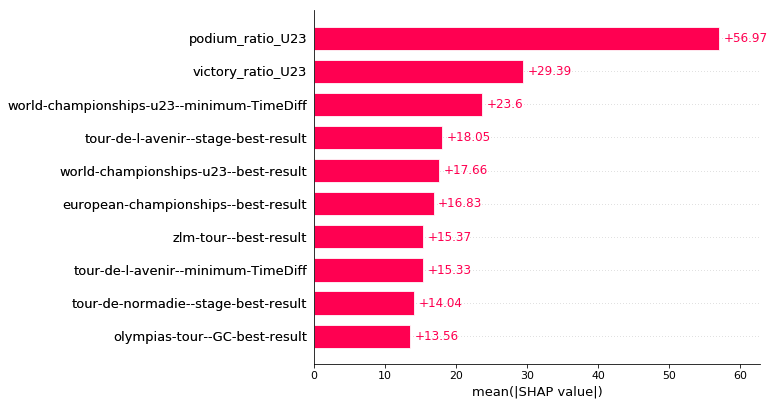

In [209]:
import shap

explainer = shap.TreeExplainer(rf_knn)
shap_values_knn = explainer(test_knn)
shap.plots.bar(shap_values_knn)

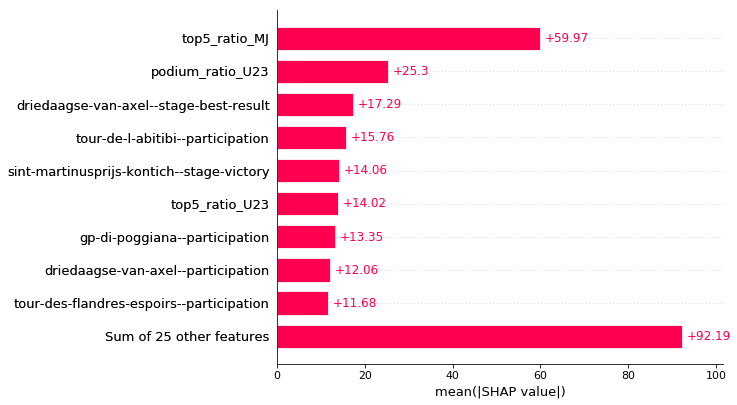

In [42]:
#Currently not used
explainer = shap.TreeExplainer(rf_mean)
shap_values_mean = explainer(test_mean)
shap.plots.bar(shap_values_mean)

# Deployment on current riders

In [15]:

print(started2020.columns)

Index(['Pro_year', 'Points_as_neopro', 'numberResults', 'nrbAbandons',
       'abandonRatio', 'victory_ratio_MJ', 'podium_ratio_MJ', 'top5_ratio_MJ',
       'victories_MJ', 'victory_ratio_U23',
       ...
       'uci.world.championships.itt.mj..best.result',
       'uci.world.championships.itt.mj..minimum.TimeDiff',
       'uci.world.championships.itt.mj..participation',
       'uci.world.championships.mj..best.result',
       'uci.world.championships.mj..minimum.TimeDiff',
       'uci.world.championships.mj..participation', 'evolutionWins',
       'evolutionPodiumRatio', 'evolutionTop5', 'Rider'],
      dtype='object', length=245)


In [16]:
started2020 = pd.read_csv('startedSince2020.csv')

started2020['predicted_points'] = 1391.267*started2020['podium_ratio_U23']+ 1190.966*started2020['top5_ratio_MJ']
started2020.sort_values(by='predicted_points', ascending=False)[['Rider', 'Pro_year']]

,Rider,Pro_year
100,repa vojtech,2021
73,larsen niklas,2020
97,pidcock thomas,2021
36,colleoni kevin,2021
118,stewart jake,2020
82,meeus jordi,2021
62,hailemichael mulu kinfe,2020
136,van gils maxim,2021
105,rodenberg frederik,2020
137,van wilder ilan,2020


In [ ]:
year = 2019
val_year = year-1

train = full[full['Pro_year']<val_year]
val = full[full['Pro_year']==val_year]
started2020 = pd.read_csv('startedSince2020.csv')
started2020.columns = started2020.columns.str.replace(".", "-")
test = started2020

train_rider = train['Rider']
val_rider = val['Rider']
test_rider = test['Rider']

y_train = train['Points_as_neopro']
y_val = val['Points_as_neopro']
y_test = test['Points_as_neopro']

train = train.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
val = val.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
test = test.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)

complete_var2 = list(complete_var)
complete_var2.remove('Rider')
complete_var2.remove('Pro_year')
complete_var2.remove('Points_as_neopro')

train_knn, val_knn, test_knn = impute('regression', train, val, test, complete_var2)
 
train_knn, val_knn, test_knn = feat_sel(train_knn, val_knn, test_knn, y_train)

X_trainBig_knn = pd.concat([train_knn, val_knn], axis = 0) 
y_trainBig = np.concatenate((y_train, y_val))

mod_current = LinearRegression()
mod_current.fit(X_trainBig_knn, y_trainBig)
predictions_current = mod_current.predict(test_knn)

In [ ]:
train_knn.columns

In [ ]:
mod_current.coef_

In [64]:
started2020['predicted_points'] = predictions_rf_knn_current
started2020.sort_values(by='predicted_points', ascending=False)[['Rider', 'Pro_year']]

,Rider,Pro_year
203,leknessund andreas,2020
97,pidcock thomas,2021
112,schelling ide,2020
82,meeus jordi,2021
80,märkl niklas,2021
145,wærenskjold søren,2021
81,mazzucco fabio,2020
73,larsen niklas,2020
105,rodenberg frederik,2020
139,vansevenant mauri,2020


# Deployment on not-yet-detected youth

In [17]:
import random
random.seed(123)

year = 2019
val_year = year-1

train = full[full['Pro_year']<val_year]
val = full[full['Pro_year']==val_year]
deployment = pd.read_csv('deploymentSet.csv')
deployment.columns = deployment.columns.str.replace(".", "-")
test = deployment

train_rider = train['Rider']
val_rider = val['Rider']
test_rider = test['Rider']

y_train = train['Points_as_neopro']
y_val = val['Points_as_neopro']

train = train.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
val = val.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
test = test.drop(['Rider'], axis=1)

complete_var2 = list(complete_var)
complete_var2.remove('Rider')
complete_var2.remove('Pro_year')
complete_var2.remove('Points_as_neopro')

train_knn, val_knn, test_knn = impute('knn', train, val, test, complete_var2)
train_knn, val_knn, test_knn = feat_sel(train_knn, val_knn, test_knn, y_train)

X_trainBig_knn = pd.concat([train_knn, val_knn], axis = 0) 
y_trainBig = np.concatenate((y_train, y_val))

rf_knn_deploy = RandomForestRegressor(n_estimators=500)
rf_knn_deploy.fit(X_trainBig_knn, y_trainBig)
predictions_rf_knn_deploy = rf_knn_deploy.predict(test_knn)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:26:43<00:00, 52.04s/it]


10 attributes confirmed important: ['tour-de-l-avenir--minimum-TimeDiff', 'podium_ratio_U23', 'victory_ratio_U23', 'zlm-tour--best-result', 'tour-de-normadie--stage-best-result', 'world-championships-u23--minimum-TimeDiff', 'olympias-tour--GC-best-result', 'tour-de-l-avenir--stage-best-result', 'european-championships--best-result', 'world-championships-u23--best-result']
231 attributes confirmed unimportant: ['paris-tours-u23--best-result', 'world-championships-itt-u23--minimum-TimeDiff', 'tour-des-flandres-espoirs--best-result', 'kattekoers--minimum-TimeDiff', 'paris-arras-tour--GC-best-result', 'tour-du-pays-de-vaud--stage-best-result', 'top5_ratio_U23', 'gp-capodarco--minimum-TimeDiff', 'ruota-d-oro-gp-festa-del-perdono--participation', 'tour-du-valromey--stage-victory', 'gran-premio-della-liberazione--participation', 'le-triptyque-des-monts-et-chateaux--stage-best-result', 'course-de-la-paix-junior--stage-best-result', 'paris-roubaix-espoirs--minimum-TimeDiff', 'paris-arras-tour--

In [148]:
46+59+59

164

In [22]:
predictions_rf_knn_deploy[4322]

108.62133333333333

In [26]:
deployment['predicted_points'] = predictions_rf_knn_deploy
deployment2 = deployment[deployment['numberResults']>10]
deployment2.sort_values(by='predicted_points', ascending=False)[['Rider', 'predicted_points']]

,Rider,predicted_points
1432,ficara pierpaolo,593.928000
108,ärm rait,460.952000
3596,roueil jules,418.556000
3103,paillot yoann,384.566000
1201,devaux thomas,379.789800
849,colnaghi luca,370.648000
193,banusch richard,368.599800
4235,van der kooij bas,366.386000
3192,peña jimenez jesus david,355.106000
104,arentsen arjan,351.922300


In [19]:
import shap

explainer = shap.TreeExplainer(rf_knn_deploy)
shap_values_deploy = explainer(test_knn)

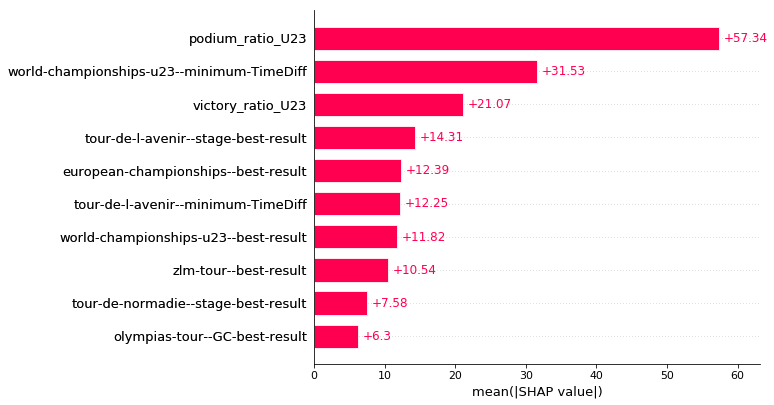

In [20]:
shap.plots.bar(shap_values_deploy)

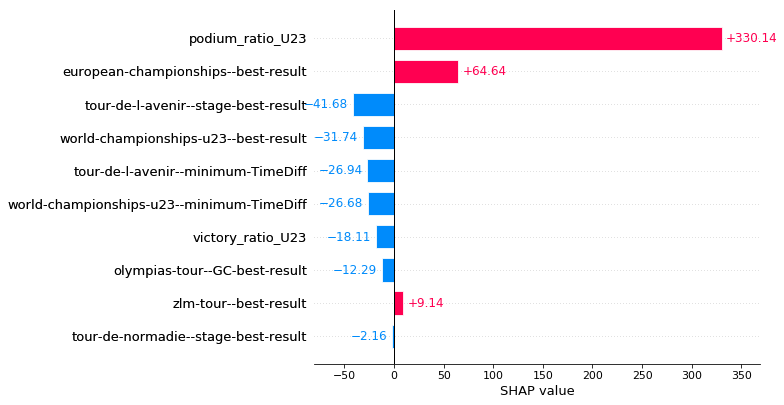

In [40]:
shap.initjs()
shap.plots.bar(shap_values_deploy[108])

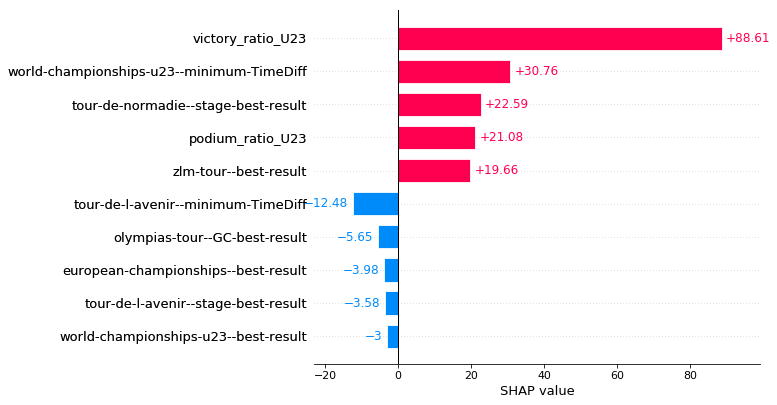

In [38]:
shap.initjs()
shap.plots.bar(shap_values_deploy[849])

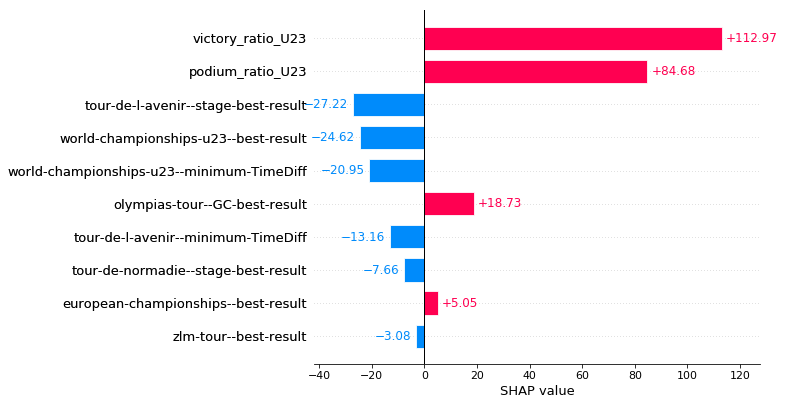

In [41]:
shap.initjs()
shap.plots.bar(shap_values_deploy[2440])

# PCA

In [42]:
import random
random.seed(123)

year = 2019
val_year = year-1

train = full[full['Pro_year']<val_year]
val = full[full['Pro_year']==val_year]
test = deployment

train_rider = train['Rider']
val_rider = val['Rider']
test_rider = test['Rider']

y_train = train['Points_as_neopro']
y_val = val['Points_as_neopro']

train = train.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
val = val.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
test = test.drop(['Rider', 'predicted_points'], axis=1)

complete_var2 = list(complete_var)
complete_var2.remove('Rider')
complete_var2.remove('Pro_year')
complete_var2.remove('Points_as_neopro')

train_knn, val_knn, test_knn = impute('knn', train, val, test, complete_var2)

X_trainBig_knn = pd.concat([train_knn, val_knn], axis = 0) 

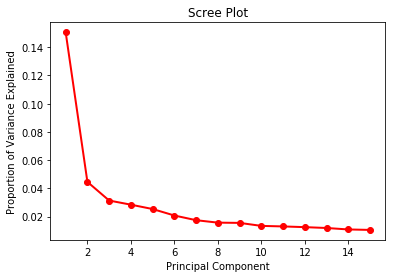

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

scaled=X_trainBig_knn.copy()
scaled=pd.DataFrame(scaler.fit_transform(scaled), columns=scaled.columns)

pca = PCA(n_components=15, svd_solver = 'auto')
Principal_components=pca.fit_transform(scaled)
pca_df = pd.DataFrame(data = Principal_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9', 'PC 10','PC 11', 'PC 12', 'PC 13', 'PC 14', 'PC 15'])

import matplotlib
import matplotlib.pyplot as plt

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [44]:
pca = PCA(n_components=4, svd_solver = 'auto')
Principal_components=pca.fit_transform(scaled)

pca_df_final = pd.DataFrame(data = Principal_components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])

In [45]:
flatten = [train_rider, val_rider]
riders = [item for sublist in flatten for item in sublist]
pca_df_final['Rider'] = riders

In [46]:
pca_df_final['PC 4'] = -pca_df_final['PC 4']

In [48]:
scaled_deploy=test_knn.copy()
scaled_deploy=pd.DataFrame(scaler.transform(scaled_deploy), columns=scaled_deploy.columns)

Principal_components2=pca.fit_transform(scaled_deploy)
deploy_pca = pd.DataFrame(data = Principal_components2, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])

deploy_pca['Rider'] = test_rider

In [49]:
deploy_pca['PC 4'] = -deploy_pca['PC 4']

In [50]:
pca_df_final[pca_df_final['Rider']=='ewan caleb']

,PC 1,PC 2,PC 3,PC 4,Rider
230,7.052059,4.796473,3.943797,1.519653,ewan caleb


In [51]:
pca_df_final[pca_df_final['Rider']=='pinot thibaut']

,PC 1,PC 2,PC 3,PC 4,Rider
557,1.337733,-1.209102,-2.857228,6.041936,pinot thibaut


In [52]:
pca_df_final[pca_df_final['Rider']=='kwiatkowski michal']

,PC 1,PC 2,PC 3,PC 4,Rider
400,7.281864,1.389509,0.049688,-5.904634,kwiatkowski michal


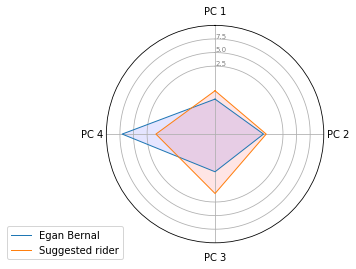

In [53]:
from math import pi

categories=list(pca_df_final)[0:4]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([2.5,5.0,7.5], ["2.5","5.0","7.5"], color="grey", size=7)
plt.ylim(-10,10)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=pca_df_final.loc[66].drop('Rider').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Egan Bernal")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=deploy_pca.loc[108].drop('Rider').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Suggested rider")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

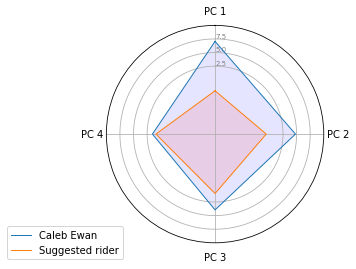

In [54]:
from math import pi

categories=list(pca_df_final)[0:4]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([2.5,5.0,7.5], ["2.5","5.0","7.5"], color="grey", size=7)
plt.ylim(-10,10)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=pca_df_final.loc[230].drop('Rider').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Caleb Ewan")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=deploy_pca.loc[108].drop('Rider').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Suggested rider")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

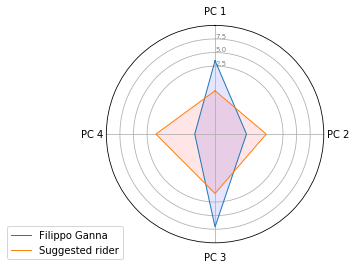

In [55]:
from math import pi

categories=list(pca_df_final)[0:4]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([2.5,5.0,7.5], ["2.5","5.0","7.5"], color="grey", size=7)
plt.ylim(-10,10)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=pca_df_final.loc[259].drop('Rider').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Filippo Ganna")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=deploy_pca.loc[108].drop('Rider').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Suggested rider")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

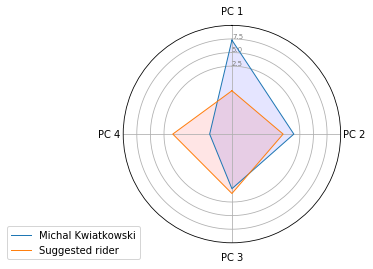

In [56]:
from math import pi

categories=list(pca_df_final)[0:4]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([2.5,5.0,7.5], ["2.5","5.0","7.5"], color="grey", size=7)
plt.ylim(-10,10)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=pca_df_final.loc[400].drop('Rider').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Michal Kwiatkowski")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=deploy_pca.loc[108].drop('Rider').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Suggested rider")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

# HEURISTIC EDITOR

In [5]:
heuristic = pd.read_csv('HeuristicEditor.csv')

In [12]:
validation(heuristic[heuristic['Pro_year']==2015]['heuristic'],heuristic[heuristic['Pro_year']==2015]['Points_as_neopro'])

[351.05880266743986,
 0.5286443894052577,
 0.8691588785046729,
 0.3363727867294026,
 0.2727272727272727,
 0.25,
 2.5]

In [13]:
validation(heuristic[heuristic['Pro_year']==2016]['heuristic'],heuristic[heuristic['Pro_year']==2016]['Points_as_neopro'])

[354.89617407419456,
 0.3083404221988918,
 0.8217821782178218,
 0.2523550014065032,
 0.36363636363636365,
 0.36363636363636365,
 3.6363636363636362]

In [14]:
validation(heuristic[heuristic['Pro_year']==2017]['heuristic'],heuristic[heuristic['Pro_year']==2017]['Points_as_neopro'])

[337.638824568559,
 0.401497271398819,
 0.8095238095238095,
 0.22969504128497364,
 0.2727272727272727,
 0.2727272727272727,
 2.727272727272727]

In [15]:
validation(heuristic[heuristic['Pro_year']==2018]['heuristic'],heuristic[heuristic['Pro_year']==2018]['Points_as_neopro'])

[349.411269534574,
 0.36096336789522887,
 0.8018867924528301,
 0.22783299629448883,
 0.18181818181818182,
 0.18181818181818182,
 1.8181818181818181]

In [16]:
validation(heuristic[heuristic['Pro_year']==2019]['heuristic'],heuristic[heuristic['Pro_year']==2019]['Points_as_neopro'])

[550.2728127559589,
 0.45534979256216396,
 0.8314606741573034,
 0.37375220458553793,
 0.3333333333333333,
 0.3333333333333333,
 3.333333333333333]

# RF & XGB without imputation

In [95]:
years = range(2015,2020)

In [166]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

lrs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
num_rounds = [50,100,150,200,250,300,350,400]
gammas = [0,4,8,12,16,20]
depths = [6,7,8,9,10,11,12]
objs = ['reg:squarederror','reg:tweedie']
reg_as = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_ls = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

def render_predictions_XGBRF(X_train, y_train, X_val, y_val, X_test):

    X_trainBig = pd.concat([X_train, X_val], axis = 0)    
    y_trainBig = np.concatenate((y_train, y_val))

    X_trainBig.columns = X_train.columns

    print('XGBoost')
    
    waarde = 0
    final_gamma = 0
    final_lr = 0
    final_rounds = 0
    final_depth = 0
    final_obj = ''
    final_alpha = 0
    final_lambda = 0
    
    for gamma in gammas:
        for lr in lrs:
            for rounds in num_rounds:
                for depth in depths:
                    for objecti in objs:
                        for reg_al in reg_as:
                            for reg_lam in reg_ls:
                                xgb_model = XGBRegressor(max_depth = depth, reg_alpha = reg_al, reg_lambda = reg_lam, objective=objecti, n_estimators=rounds, gamma = gamma, eta = lr)
                                xgb_model.fit(X_train, y_train)
                                predictions = xgb_model.predict(X_val)
                                waarde2 = spearmanr(y_val, predictions).correlation
                                if waarde2>waarde:                    
                                    final_gamma = gamma
                                    final_lr = lr
                                    final_rounds = rounds
                                    final_depth = depth
                                    final_obj = objecti
                                    final_alpha = reg_al
                                    final_lambda = reg_lam
                                    waarde = waarde2
                                    print(waarde2)
                                    print('update')
 
    xgb_model = XGBRegressor(max_depth = final_depth, reg_alpha = final_alpha, reg_lambda = final_lambda, objective=final_obj, n_estimators=final_rounds, gamma = final_gamma, eta = final_lr)
    xgb_model.fit(X_trainBig, y_trainBig)    
    predictions_xgb = xgb_model.predict(X_test)

    return(predictions_xgb)

In [167]:
years = range(2015,2020)

def loop2(year): 
  val_year = year-1

  train = full[full['Pro_year']<val_year]
  val = full[full['Pro_year']==val_year]
  test = full[full['Pro_year']==year]

  train_rider = train['Rider']
  val_rider = val['Rider']
  test_rider = test['Rider']

  y_train = train['Points_as_neopro']
  y_val = val['Points_as_neopro']
  y_test = test['Points_as_neopro']

  train = train.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
  val = val.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
  test = test.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)

  complete_var2 = list(complete_var)
  complete_var2.remove('Rider')
  complete_var2.remove('Pro_year')
  complete_var2.remove('Points_as_neopro')

  predictions_xgb = render_predictions_XGBRF(train,  y_train, val, y_val, test)
  
  validation_xgb = validation(predictions_xgb, y_test)

  return(validation_xgb)

In [168]:
import random
random.seed(123)
outcome_2015_v2 = loop2(2015)
outcome_2016_v2 = loop2(2016)
outcome_2017_v2 = loop2(2017)
outcome_2018_v2 = loop2(2018)
outcome_2019_v2 = loop2(2019)

XGBoost
395.35386763872725
update
394.66774040705513
update
393.55573496965184
update
391.381555326296
update
385.5179792632813
update
376.91667081134005
update
376.8439854492899
update
362.78778259481584
update
350.9393050479257
update
348.5752927060145
update
XGBoost
345.7172511772374
update
345.2766901915495
update
344.5562717381481
update
343.1312650062401
update
338.9989122064078
update
332.34869376797616
update
332.1526528026024
update
319.1906253182454
update
289.94874771531596
update
264.6917434614769
update
260.8288902227929
update
254.16251484062073
update
253.73440075374367
update
XGBoost
341.128375428593
update
340.60505160791075
update
339.73966665918806
update
338.0357084160164
update
332.9254157591026
update
324.92964878220295
update
324.9137085680945
update
311.80867437769206
update
287.0293730437312
update
267.90718578588326
update
266.8744978722588
update
260.390545805788
update
XGBoost
318.1528654364164
update
317.72307509430306
update
317.01181776022315
update
315.6

In [169]:
outcome_2015_v2

[299.11850491992914,
 SpearmanrResult(correlation=0.4162466917108322, pvalue=5.003574650236984e-06),
 0.8214285714285714,
 0.26547481308716875,
 0.25,
 0.25,
 2.5]

In [170]:
outcome_2016_v2

[302.51526109672517,
 SpearmanrResult(correlation=0.42132005746757367, pvalue=4.570277641776925e-06),
 0.8,
 0.2559167009749161,
 0.25,
 0.25,
 2.5]

In [171]:
outcome_2017_v2

[266.98515625611384,
 SpearmanrResult(correlation=0.2951822031900452, pvalue=0.0012339613809144122),
 0.7606837606837606,
 0.23715863145174218,
 0.3333333333333333,
 0.3333333333333333,
 3.333333333333333]

In [172]:
outcome_2018_v2

[271.70356520989037,
 SpearmanrResult(correlation=0.48962447363708833, pvalue=2.9399341345102525e-09),
 0.8854961832061069,
 0.43103328228393034,
 0.35714285714285715,
 0.35714285714285715,
 3.571428571428571]

In [173]:
outcome_2019_v2

[459.26103998803194,
 SpearmanrResult(correlation=0.465424976812819, pvalue=3.4080676915426114e-07),
 0.7981651376146789,
 0.1857586227138444,
 0.09090909090909091,
 0.09090909090909091,
 0.9090909090909091]

# Iterative KNN

In [114]:
from xgboost.sklearn import XGBRegressor

def imputeK(k, imputation_method, train, val, test, complete_var):
    
    if imputation_method=='mean':
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    elif  imputation_method=='regression':    
        imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=500), max_iter=10, random_state=516)
    elif  imputation_method=='knn':  
        imputer = KNNImputer(n_neighbors=k, weights="uniform")    
    else:
        print('wrong imputation method')
    
    flat_list = [item for sublist in t for item in sublist]
    with_complete = [complete_var, flat_list]
    col_store = [item for sublist in with_complete for item in sublist]

    if imputation_method=='knn': 
        

        train_impute =  train[complete_var]
        test_impute = test[complete_var]
        val_impute = val[complete_var]
        
        for columns in t:
            total_col = [columns, complete_var]
            total_col = [item for sublist in total_col for item in sublist]

            train_tussen = train[total_col]
            test_tussen = test[total_col]
            val_tussen = val[total_col]

            imputer.fit(train_tussen)

            train_tussen = pd.DataFrame(imputer.transform(train_tussen))
            test_tussen = pd.DataFrame(imputer.transform(test_tussen))
            val_tussen = pd.DataFrame(imputer.transform(val_tussen))

            train_tussen.columns = total_col
            test_tussen.columns = total_col
            val_tussen.columns = total_col

            train_tussen = train_tussen[columns]
            test_tussen = test_tussen[columns]
            val_tussen = val_tussen[columns]

            train_impute.reset_index(drop=True, inplace=True)
            train_tussen.reset_index(drop=True, inplace=True)
            val_impute.reset_index(drop=True, inplace=True)
            val_tussen.reset_index(drop=True, inplace=True)
            test_impute.reset_index(drop=True, inplace=True)
            test_tussen.reset_index(drop=True, inplace=True)

            train_impute = pd.concat([train_impute, train_tussen], axis = 1, ignore_index = True)
            val_impute = pd.concat([val_impute, val_tussen], axis = 1, ignore_index = True)
            test_impute = pd.concat([test_impute, test_tussen], axis = 1, ignore_index = True)


    else:
        train_impute = train
        val_impute = val
        test_impute = test
        
        imputer.fit(train_impute)

        train_impute = pd.DataFrame(imputer.transform(train_impute))
        val_impute = pd.DataFrame(imputer.transform(val_impute))
        test_impute = pd.DataFrame(imputer.transform(test_impute))    

    train_impute.columns = col_store 
    val_impute.columns = col_store 
    test_impute.columns = col_store
       
    return(train_impute, val_impute, test_impute) 

In [119]:
def loop3(year):
  
  print(year)  
  val_year = year-1

  train = full[full['Pro_year']<val_year]
  val = full[full['Pro_year']==val_year]
  test = full[full['Pro_year']==year]

  train_rider = train['Rider']
  val_rider = val['Rider']
  test_rider = test['Rider']

  y_train = train['Points_as_neopro']
  y_val = val['Points_as_neopro']
  y_test = test['Points_as_neopro']

  train = train.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
  val = val.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)
  test = test.drop(['Rider', 'Pro_year', 'Points_as_neopro'], axis=1)

  complete_var2 = list(complete_var)
  complete_var2.remove('Rider')
  complete_var2.remove('Pro_year')
  complete_var2.remove('Points_as_neopro')
  
  all_data = [] 
  for neighbors in range(1,11):
    print(neighbors)    
    train_knn, val_knn, test_knn = imputeK(neighbors, 'knn', train, val, test, complete_var2)  
    train_knn, val_knn, test_knn = feat_sel(train_knn, val_knn, test_knn, y_train)
    X_trainBig_knn = pd.concat([train_knn, val_knn], axis = 0) 
    y_trainBig = np.concatenate((y_train, y_val))

    rf = RandomForestRegressor(n_estimators=500)
    rf.fit(X_trainBig_knn, y_trainBig)
    predictions = rf.predict(test_knn)
    pred_percentile = np.vectorize(lambda x: percentileofscore(predictions, x))(predictions)
    all_data.append(pd.Series(pred_percentile))
    
  df = pd.concat(all_data, axis=1)
  final_predictions = df.mean(axis=1)
  
  finalval = validation(predictions, y_test)

  return(finalval)

In [120]:
import random
random.seed(123)
outcome_2015_v3 = loop3(2015)
outcome_2016_v3 = loop3(2016)
outcome_2017_v3 = loop3(2017)
outcome_2018_v3 = loop3(2018)
outcome_2019_v3 = loop3(2019)

2015
1
2
3
4
5
6
7
8
9
10
2016
1
2
3
4
5
6
7
8
9
10
2017
1
2
3
4
5
6
7
8
9
10
2018
1
2
3
4
5
6
7
8
9
10
2019
1
2
3
4
5
6
7
8
9
10


In [121]:
outcome_2015_v3

[245.62195754720568,
 SpearmanrResult(correlation=0.6322511184935893, pvalue=7.626630737855832e-14),
 0.5446428571428571,
 0.8839285714285714]

In [122]:
outcome_2016_v3

[265.7735858676055,
 SpearmanrResult(correlation=0.5022763054526703, pvalue=2.2600876507347366e-08),
 0.4727272727272727,
 0.8363636363636364]

In [123]:
outcome_2017_v3

[239.94969562457197,
 SpearmanrResult(correlation=0.40984756372741243, pvalue=4.457427112474006e-06),
 0.4358974358974359,
 0.7692307692307692]

In [124]:
outcome_2018_v3

[228.5436952219383,
 SpearmanrResult(correlation=0.5013033642097302, pvalue=1.0690334837178972e-09),
 0.5267175572519084,
 0.8854961832061069]

In [125]:
outcome_2019_v3

[422.2695695459047,
 SpearmanrResult(correlation=0.5797569646747421, pvalue=3.9563785214089934e-11),
 0.5596330275229358,
 0.8807339449541285]